## Camera calibration
$$
\begin{pmatrix}
u \\
v \\
1
\end{pmatrix}
= P\begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
= K [R|t] \begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
$$

Intrinsic param: K

Extrinsic param: R, t

We note that R is orthogonal by virtue of being a rotation matrix, and K is upper-triangular

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

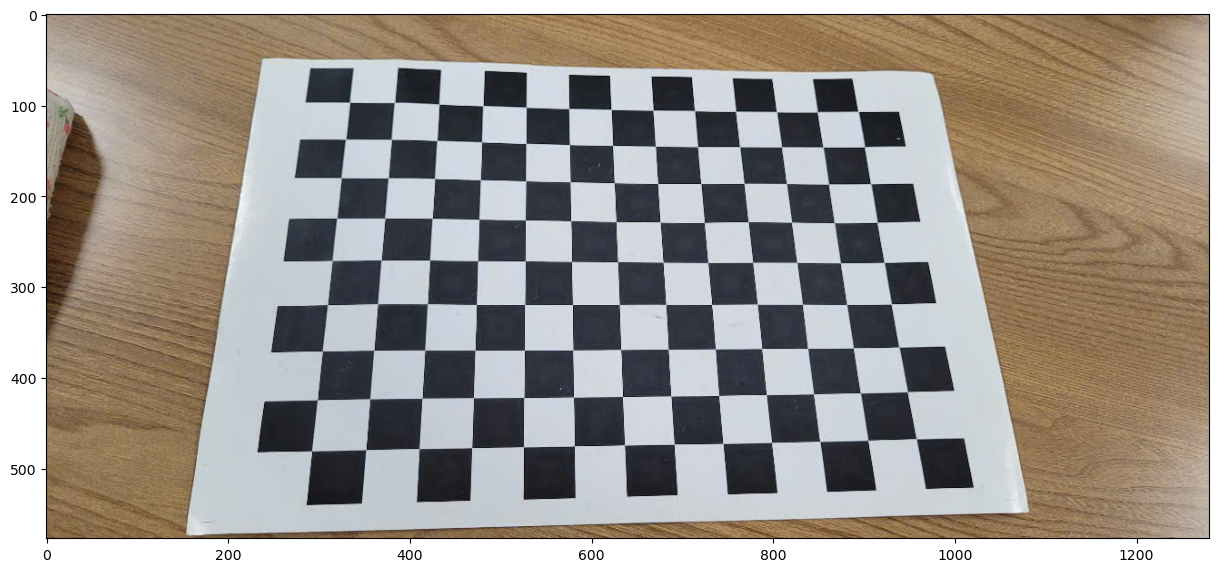

In [2]:
plt.figure(figsize=(15, 9))
plt.imshow(plt.imread("assets/data_2.jpg"))

### 1. Find corner coordinates

(577, 1280)


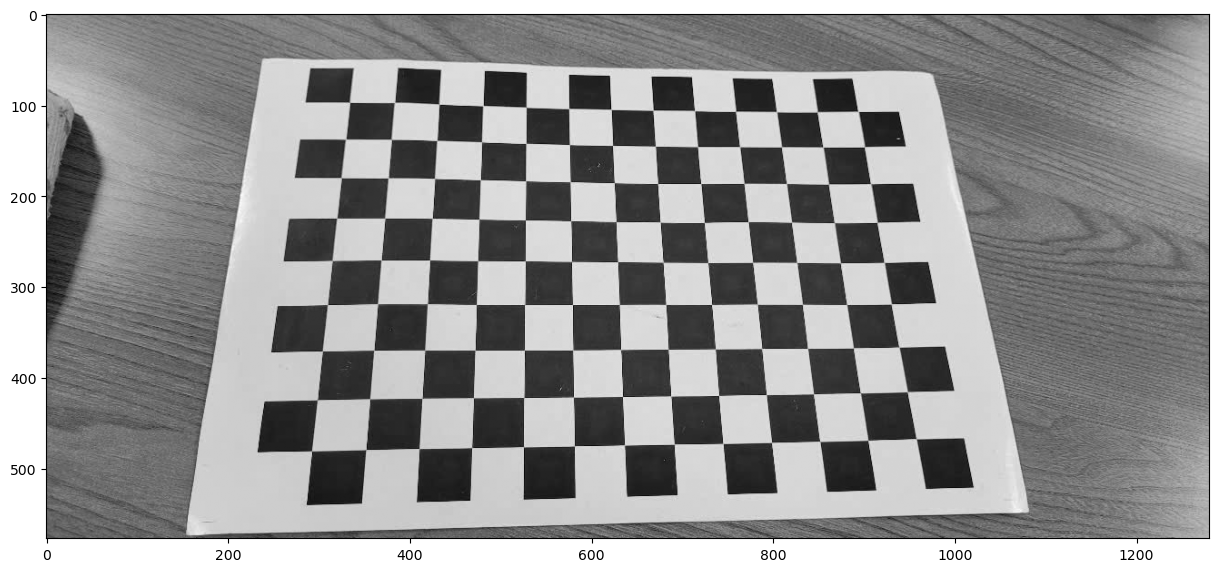

In [21]:
image = cv2.imread("assets/data_2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(15, 9))
plt.imshow(gray, cmap="gray")
print(gray.shape)

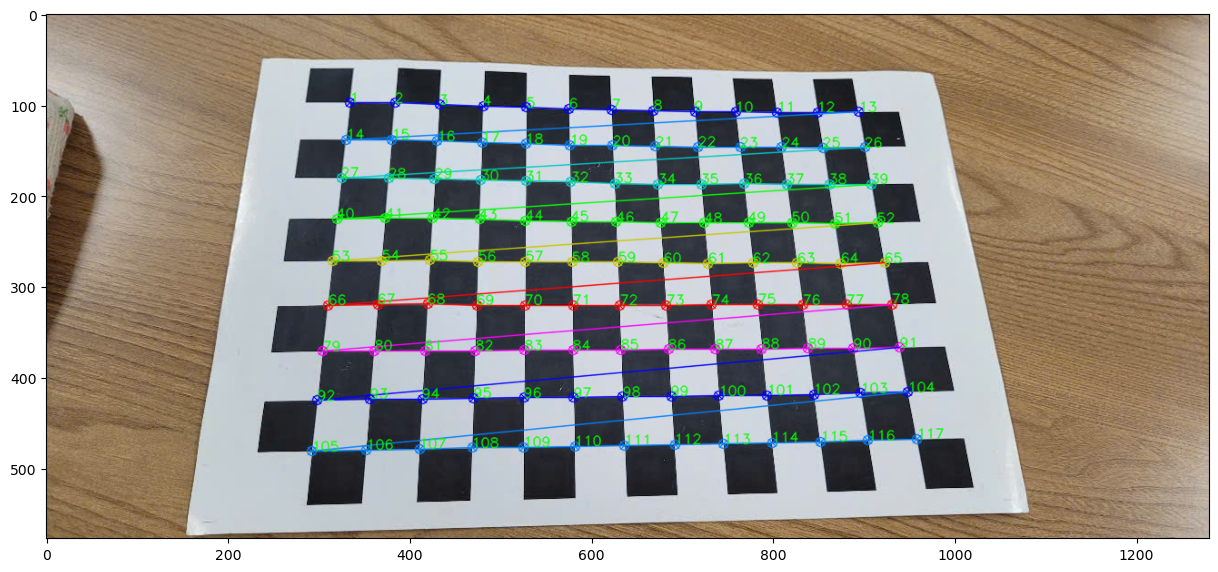

In [22]:
ret, corners = cv2.findChessboardCorners(gray, (13,9), None)
if ret:
    corners = np.squeeze(corners, axis=1)
    cv2.drawChessboardCorners(image, (13, 9), corners, ret)
    for i in range(len(corners)):
        cv2.putText(image, f'{i + 1}', corners[i].astype(int),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
    
plt.figure(figsize=(15, 9))
plt.imshow(image)

In [5]:
# Corners in object coordinate

# X and Y
x, y = np.meshgrid(np.arange(0, 13), np.arange(0, 9))
coordinates = np.stack((x.ravel(), y.ravel()), axis=1)

# Z
obj_points = np.hstack((coordinates, np.zeros((coordinates.shape[0], 1), dtype=float)))

obj_points = obj_points * 20

print(f"Position of {len(obj_points)} corners in object coordinates")
print(f"Has shape {obj_points.shape}")
print(f"Example:\n{obj_points[:5]}")

Position of 117 corners in object coordinates
Has shape (117, 3)
Example:
[[ 0.  0.  0.]
 [20.  0.  0.]
 [40.  0.  0.]
 [60.  0.  0.]
 [80.  0.  0.]]


## 2. Find P

$$
\begin{pmatrix}
u \\
v \\
1
\end{pmatrix}
= P\begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
=
\begin{pmatrix}
p_{11} & p_{12} & p_{13} & p_{14} \\
p_{21} & p_{22} & p_{23} & p_{24} \\
p_{31} & p_{32} & p_{33} & p_{34}
\end{pmatrix}
\begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
$$
Then
$$
u = \frac{p_{11}X + p_{12}Y + p_{13}Z + p_{14}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}
$$
$$
v = \frac{p_{21}X + p_{22}Y + p_{23}Z + p_{24}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}
$$
In other words,
$$
p_{11}X + p_{12}Y + p_{13}Z + p_{14} - u.p_{31}X - u.p_{32}Y - u.p_{33}Z - u.p_{34} = 0
$$
$$
p_{21}X + p_{22}Y + p_{23}Z + p_{24} - v.p_{31}X - v.p_{32}Y - v.p_{33}Z - v.p_{34} = 0
$$

So
$$
\underbrace{\begin{pmatrix}
X & Y & Z & 1 & 0 & 0 & 0 & 0 & -uX & -uY & -uZ & -u \\
0 & 0 & 0 & 0 & X & Y & Z & 1 & -vX & -vY & -vZ & -v
\end{pmatrix}}_{A \text{ (known)}}
\underbrace{\begin{pmatrix}
p_{11} \\ p_{12} \\ p_{13} \\ p_{14} \\ p_{21} \\ p_{22} \\ p_{23} \\ p_{24} \\ p_{31} \\ p_{32} \\ p_{33} \\ p_{34}
\end{pmatrix}}_{p \text{ (unknown)}}=0
$$

We want $Ap$ as close as 0 as possible and $||p||$ = 1:
$$
min||Ap||^2 \text{ such that } ||p||^2 = 1\\
min(p^T A^T Ap) \text{ such that } p^T p = 1
$$

Define loss function:
$$
L(p, \lambda) = p^T A^T Ap - \lambda(p^T p - 1)
$$

Derivatives of loss function with respect to p:
$$
2A^T Ap - 2\lambda p
$$

Then $p$ is an eigenvector with smallest eigenvalue $\lambda$ of matrix $A^T A$ minimizes the loss function $L$
(Source: [Slide, page 134-142](https://www.cs.cmu.edu/~16385/lectures/lecture10.pdf))

In [6]:
A = []
for img_point, obj_point in zip (corners, obj_points):
    r = np.hstack([obj_point, 1])
    A.append(np.concatenate([r, 0 * r, -img_point[0] * r]))
    A.append(np.concatenate([0 * r, r, -img_point[1] * r]))

A = np.array(A, dtype=float)
A.shape

(234, 12)

In [7]:
ATA = np.dot(A.T, A)
ATA.shape


(12, 12)

In [8]:
values, vectors = np.linalg.eig(ATA)
values

array([2.15807221e+12, 2.00073221e+11, 6.62918444e+06, 2.92500305e+06,
       4.68350372e+05, 4.01132263e+04, 1.19495459e+04, 1.70248258e+01,
       6.55049598e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [9]:
XYZ1 = np.hstack([obj_points, np.ones((obj_points.shape[0], 1))])

In [10]:
for i, eigenvalue in enumerate(values):
    p = vectors[i]
    p_matrix = vectors[i].reshape(-1, 4)
    Ap = np.dot(A, p)
    norm_Ap = np.linalg.norm(Ap)
    print(f"Eigenvalue: {eigenvalue}")
    print(f"Norm Ap: {norm_Ap}")

    uv1 = np.transpose(np.dot(p_matrix, XYZ1.T))
    uv1[:, :2] /= uv1[:, 2][:, np.newaxis]  # Divide x and y by z
    uv1[:, 2] = 1  # Set the last column to 1
    print(f"Image points:\n{uv1[:5]}\n...\n\n\n")

Eigenvalue: 2158072214918.6143
Norm Ap: 9433.93059446566
Image points:
[[        inf        -inf  1.        ]
 [-2.22250042 13.64027626  1.        ]
 [-1.17570273 13.60716836  1.        ]
 [-0.82677017 13.59613239  1.        ]
 [-0.65230389 13.59061441  1.        ]]
...



Eigenvalue: 200073221464.09323
Norm Ap: 2279.206392031697
Image points:
[[          inf           inf    1.        ]
 [   7.62329932 -357.14619405    1.        ]
 [   3.9633588  -357.16456781    1.        ]
 [   2.74337863 -357.1706924     1.        ]
 [   2.13338855 -357.17375469    1.        ]]
...



Eigenvalue: 6629184.4369574925
Norm Ap: 794102.3140279942
Image points:
[[nan nan  1.]
 [nan nan  1.]
 [nan nan  1.]
 [nan nan  1.]
 [nan nan  1.]]
...



Eigenvalue: 2925003.0456309896
Norm Ap: 1261127.2393747412
Image points:
[[            inf            -inf  1.00000000e+00]
 [-1.20866023e-04  1.85585065e-02  1.00000000e+00]
 [-6.33245518e-05  1.12277369e-02  1.00000000e+00]
 [-4.41440614e-05  8.78414701e-03  1.000

/tmp/ipykernel_83376/3393335625.py:10: RuntimeWarning: divide by zero encountered in divide
  uv1[:, :2] /= uv1[:, 2][:, np.newaxis]  # Divide x and y by z
/tmp/ipykernel_83376/3393335625.py:10: RuntimeWarning: invalid value encountered in divide
  uv1[:, :2] /= uv1[:, 2][:, np.newaxis]  # Divide x and y by z


### 3. Find K, R, t
Finds the camera intrinsic (K) and extrinsic parameters (R, t) from several views of a calibration pattern.

But I did something wrong and can not find a proper P that
$$
\begin{pmatrix}
u \\
v \\
1
\end{pmatrix}
= P\begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
$$

# **Using OpenCV**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

(577, 1280)


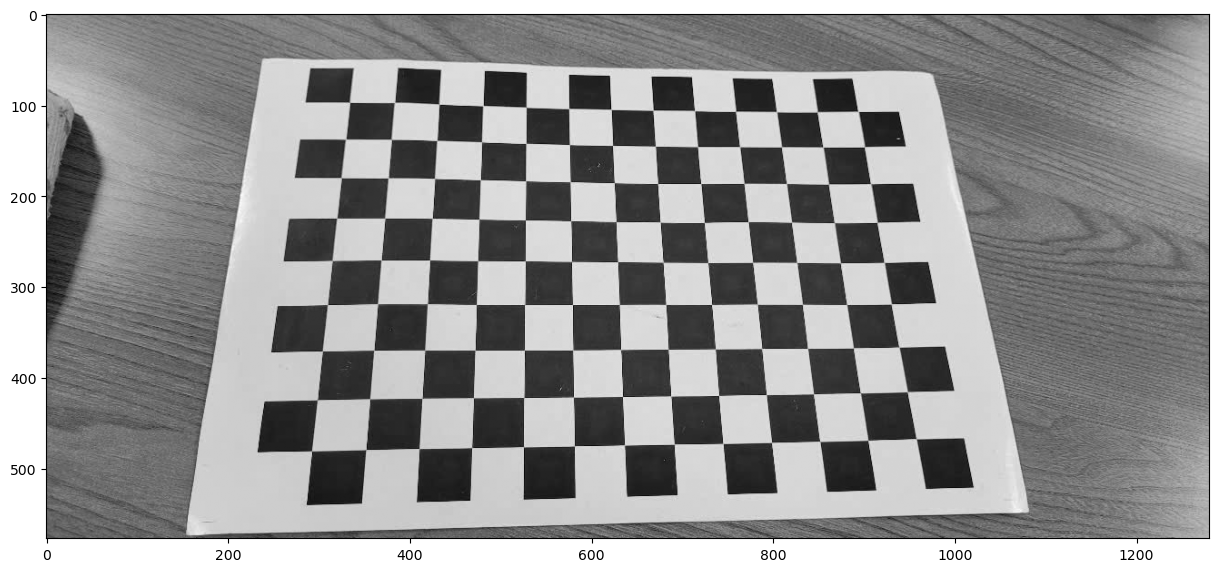

In [2]:
image = cv2.imread("assets/data_2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
copy_1 = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(15, 9))
plt.imshow(gray, cmap="gray")
print(gray.shape)

[[[334.26382   98.24036 ]]

 [[383.53574   98.32807 ]]

 [[432.47845  100.102684]]

 [[481.05     101.79417 ]]

 [[528.42084  103.50455 ]]

 [[575.5114   105.10925 ]]

 [[622.05804  106.0791  ]]

 [[668.1941   106.89829 ]]

 [[713.69183  107.38013 ]]

 [[759.21173  108.2142  ]]

 [[804.0993   108.493546]]

 [[849.0412   108.79827 ]]

 [[893.8242   108.21307 ]]

 [[329.7352   138.68323 ]]

 [[380.22876  138.86418 ]]

 [[430.19998  140.25331 ]]

 [[479.4876   141.784   ]]

 [[528.297    143.3569  ]]

 [[576.2516   144.64558 ]]

 [[623.5269   145.51433 ]]

 [[670.68884  146.37936 ]]

 [[717.3577   146.78534 ]]

 [[763.5065   146.84145 ]]

 [[809.5313   147.15576 ]]

 [[855.18054  147.25278 ]]

 [[900.73413  147.13339 ]]

 [[324.97946  181.05107 ]]

 [[376.58835  181.2376  ]]

 [[427.62946  181.82498 ]]

 [[478.17252  183.41522 ]]

 [[527.8001   184.54346 ]]

 [[576.98804  185.53961 ]]

 [[625.2674   186.56297 ]]

 [[673.5244   187.49034 ]]

 [[720.7481   187.5307  ]]

 [[768.22546  187.36

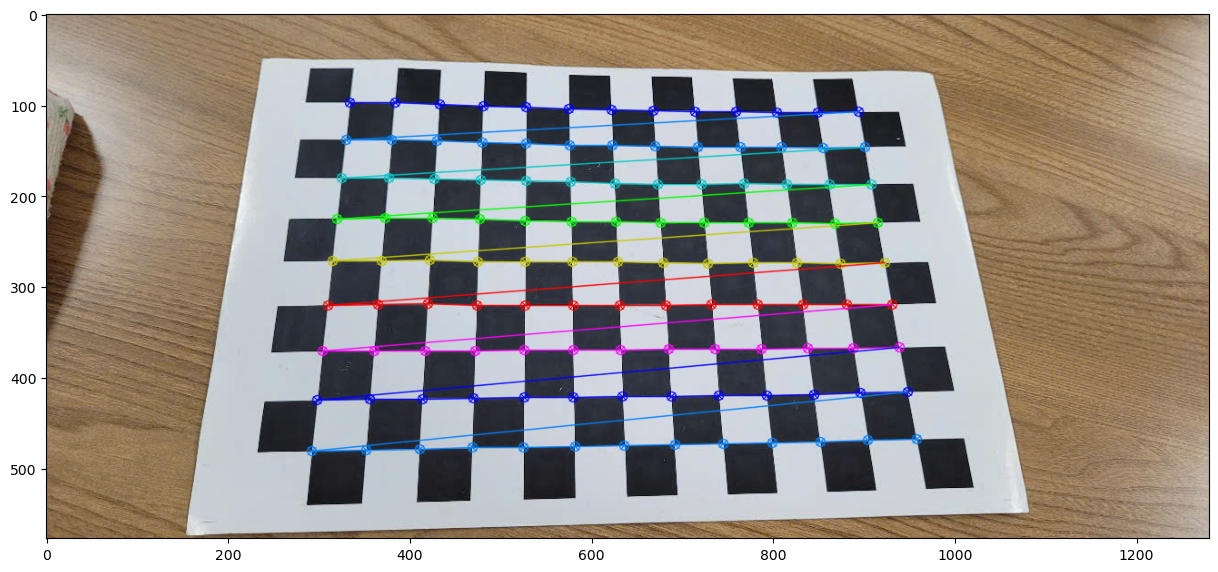

In [3]:
ret, corners = cv2.findChessboardCorners(gray, (13,9), None)
if ret:
    cv2.drawChessboardCorners(copy_1, (13, 9), corners, ret)    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    img_points = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)

plt.figure(figsize=(15, 9))
plt.imshow(copy_1)
print(img_points)

In [4]:
# X and Y
x, y = np.meshgrid(np.arange(0, 13), np.arange(0, 9))
coordinates = np.stack((x.ravel(), y.ravel()), axis=1)

# Z
obj_points = np.hstack((coordinates, np.zeros((coordinates.shape[0], 1), dtype=float)))
obj_points = obj_points * 20
obj_points

array([[  0.,   0.,   0.],
       [ 20.,   0.,   0.],
       [ 40.,   0.,   0.],
       [ 60.,   0.,   0.],
       [ 80.,   0.,   0.],
       [100.,   0.,   0.],
       [120.,   0.,   0.],
       [140.,   0.,   0.],
       [160.,   0.,   0.],
       [180.,   0.,   0.],
       [200.,   0.,   0.],
       [220.,   0.,   0.],
       [240.,   0.,   0.],
       [  0.,  20.,   0.],
       [ 20.,  20.,   0.],
       [ 40.,  20.,   0.],
       [ 60.,  20.,   0.],
       [ 80.,  20.,   0.],
       [100.,  20.,   0.],
       [120.,  20.,   0.],
       [140.,  20.,   0.],
       [160.,  20.,   0.],
       [180.,  20.,   0.],
       [200.,  20.,   0.],
       [220.,  20.,   0.],
       [240.,  20.,   0.],
       [  0.,  40.,   0.],
       [ 20.,  40.,   0.],
       [ 40.,  40.,   0.],
       [ 60.,  40.,   0.],
       [ 80.,  40.,   0.],
       [100.,  40.,   0.],
       [120.,  40.,   0.],
       [140.,  40.,   0.],
       [160.,  40.,   0.],
       [180.,  40.,   0.],
       [200.,  40.,   0.],
 

In [5]:
obj_points_of_imgs = np.expand_dims(obj_points, axis=0).astype(np.float32)
img_points_of_imgs = np.expand_dims(img_points, axis=0).astype(np.float32)
ret, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    obj_points_of_imgs, img_points_of_imgs, gray.shape[0:2], None, None)

In [7]:
intrinsics

array([[1.48902397e+03, 0.00000000e+00, 3.38654656e+02],
       [0.00000000e+00, 2.10341818e+03, 8.15740450e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [8]:
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))
extrinsics

[array([[ 9.89030079e-01, -1.09539068e-01,  9.90994176e-02,
          3.34110880e+00],
        [ 1.48589432e-02,  7.41260113e-01,  6.71053393e-01,
         -2.01023697e+02],
        [-1.46965009e-01, -6.62219478e-01,  7.34756183e-01,
          6.34264848e+02]])]

#### **Reverse test**

In [9]:
P = np.dot(intrinsics, extrinsics[0])

In [10]:
# Input: X = 0, Y = 0, X = 0 (world coordinate)
# Expect output: x = 334.26132 y = 98.23913 (image coordinate)

x = np.array([0, 0, 0, 1], dtype=np.float32).T
u = np.dot(P, x)
u = u / u[2]
u

array([346.49836891, 149.0837706 ,   1.        ])

#### Draw the output

In [13]:
XYZ1 = np.hstack([obj_points, np.ones((obj_points.shape[0], 1))])
print(XYZ1.shape)
XYZ1[:3]

(117, 4)


array([[ 0.,  0.,  0.,  1.],
       [20.,  0.,  0.,  1.],
       [40.,  0.,  0.,  1.]])

In [16]:
uv1 = np.transpose(np.dot(P, XYZ1.T))
uv1[:, 0] = uv1[:, 0] / uv1[:, 2]
uv1[:, 1] = uv1[:, 1] / uv1[:, 2]
uv1[:, 2] = 1
uv1

array([[3.46498369e+02, 1.49083771e+02, 1.00000000e+00],
       [3.93188773e+02, 1.46970102e+02, 1.00000000e+00],
       [4.40315969e+02, 1.44836661e+02, 1.00000000e+00],
       [4.87886116e+02, 1.42683167e+02, 1.00000000e+00],
       [5.35905488e+02, 1.40509337e+02, 1.00000000e+00],
       [5.84380478e+02, 1.38314881e+02, 1.00000000e+00],
       [6.33317601e+02, 1.36099504e+02, 1.00000000e+00],
       [6.82723499e+02, 1.33862906e+02, 1.00000000e+00],
       [7.32604939e+02, 1.31604780e+02, 1.00000000e+00],
       [7.82968819e+02, 1.29324814e+02, 1.00000000e+00],
       [8.33822174e+02, 1.27022690e+02, 1.00000000e+00],
       [8.85172174e+02, 1.24698082e+02, 1.00000000e+00],
       [9.37026129e+02, 1.22350661e+02, 1.00000000e+00],
       [3.41412802e+02, 1.85079588e+02, 1.00000000e+00],
       [3.89079515e+02, 1.83091807e+02, 1.00000000e+00],
       [4.37201755e+02, 1.81085029e+02, 1.00000000e+00],
       [4.85786082e+02, 1.79058982e+02, 1.00000000e+00],
       [5.34839185e+02, 1.77013

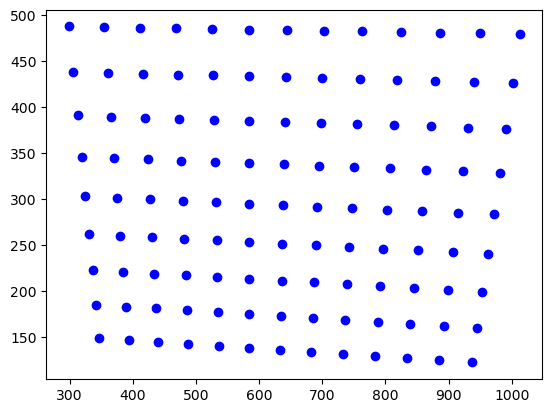

In [17]:
plt.scatter(uv1[:, 0], uv1[:, 1], color='blue')

[346.49836891 149.0837706    1.        ]
[393.18877306 146.97010249   1.        ]
[440.31596943 144.83666086   1.        ]
[487.88611617 142.68316693   1.        ]
[535.90548771 140.50933666   1.        ]
[584.38047759 138.31488061   1.        ]
[633.31760121 136.09950383   1.        ]
[682.72349883 133.86290571   1.        ]
[732.60493851 131.60477987   1.        ]
[782.96881924 129.32481399   1.        ]
[833.82217411 127.02268969   1.        ]
[885.17217359 124.69808235   1.        ]
[937.02612887 122.350661     1.        ]
[341.4128025  185.07958819   1.        ]
[389.07951515 183.0918069    1.        ]
[437.20175453 181.08502939   1.        ]
[485.78608184 179.05898204   1.        ]
[534.83918491 177.01338597   1.        ]
[584.36788123 174.94795686   1.        ]
[634.37912117 172.86240488   1.        ]
[684.87999117 170.75643451   1.        ]
[735.8777171  168.62974442   1.        ]
[787.37966774 166.48202733   1.        ]
[839.3933583  164.31296982   1.        ]
[891.92645407 16

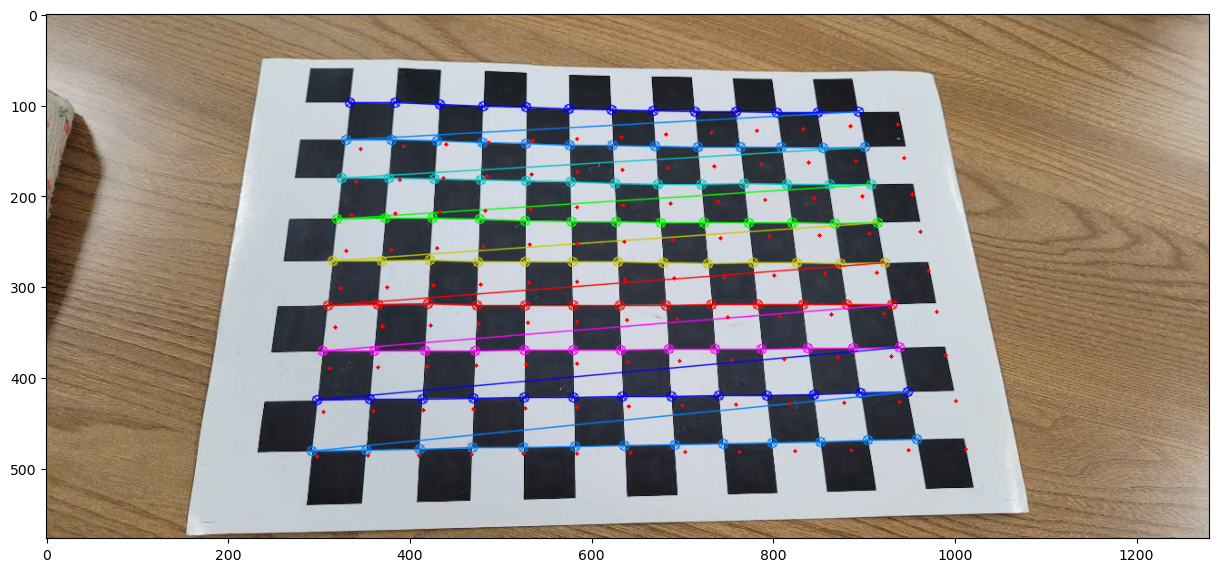

In [21]:
copy_2 = image.copy()
for point in uv1:
    print(point)
    cv2.circle(copy_2, point[:2].astype(int), 2, (255, 0, 0), -1)  # Green points with a radius of 5

plt.figure(figsize=(15, 9))
plt.imshow(copy_2)
print(img_points)